# Linear Regression to predict Game Margin
## By: Ryan O'Farrell


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import altair as alt
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

Read in data via loop from 2003-2019 seasons.

In [2]:
first_run = True
for season in range(2003,2020):
    if first_run:
        raw_data = pd.read_csv('data/predate_games/'+str(season)+'.csv')
        first_run = False
    else:
        data_to_append = pd.read_csv('data/predate_games/'+str(season)+'.csv')
        raw_data = raw_data.append(data_to_append, sort=False)
        del data_to_append

Let's make a copy of the raw data so we can always come back and rerun from here

In [3]:
df = raw_data.copy()
df.shape

(167868, 190)

The data contains a record from each team's perspective in the game, so there are actually two times as many records as there should be. Let's get to just one record per game by:

- Keeping the home team
- Keeping the earlier alphabetical team when the location is neutral.

In [4]:
df = df.loc[(df['Tm1_Loc'] == 'H') | ((df['Tm1_Loc'] == 'N') & (df['Tm1'] < df['Tm2']))]
df.shape

(83934, 190)

Exactly half of the records remain. There also are games early-on in the season, where the teams do not have a large sample size of prior-games to have any meaningful data. Let's see what that looks like:

In [5]:
df[['Tm1_TmGame', 'Tm2_TmGame']].describe()

,Tm1_TmGame,Tm2_TmGame
count,83934.000000,83934.000000
mean,15.221484,15.162747
std,8.429087,8.482553
min,1.000000,1.000000
25%,8.000000,8.000000
50%,15.000000,15.000000
75%,22.000000,22.000000
max,35.000000,34.000000


The min of 1 illustrates the point. Let's set a threshold of 10 previous games by both teams as a large enough sample size to keep the record.

In [6]:
game_threshold = 10
df = df.loc[((df['Tm1_TmGame'] >= game_threshold) & (df['Tm2_TmGame'] >= game_threshold))]
df.shape

(56113, 190)

Now we are down to 56,113 records - still quite a few! Let's look at the field we want to predict: Tm1_GameMargin:

In [7]:
y = df['Tm1_GameMargin']
del df['Tm1_GameMargin']
y.describe()

count    56113.000000
mean         3.593677
std         13.219671
min        -59.000000
25%         -5.000000
50%          4.000000
75%         12.000000
max         74.000000
Name: Tm1_GameMargin, dtype: float64

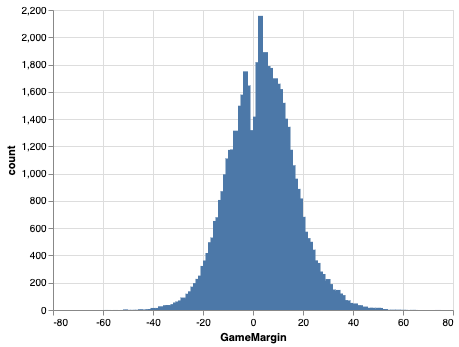

In [8]:
np_bins = np.arange(-60,76,1)
hist, bin_edges = np.histogram(y, bins = np_bins)
chart_data = pd.DataFrame({
    'GameMargin': bin_edges[:-1],
    'count': hist
})


alt.Chart(
    chart_data
).mark_bar().encode(
    x = alt.X('GameMargin'),
    y='count'
)

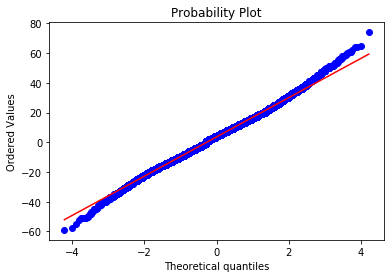

In [9]:
stats.probplot(y, dist='norm', plot=plt)
plt.show()

Data looks normal with a mean of approx. 3.6; remember we kept mostly home teams so this could be considered the home court advantage. Note the dip in the distribution at 0 points - since games don't end in ties, no margins should be 0

In [10]:
assert hist[np.where(np_bins == 0)][0] == 0, 'Some games are ties!!'

The fields in the data are summations of the key metrics for each game played prior to the given game. We would rather have normalized values, by game, by 40 minutes, and by possession.

In [11]:
METRICS = ['PF', 'Margin',
            'FGM', 'FGA',
            'FG3M', 'FG3A',
            'FG2M', 'FG2A',
            'FTA', 'FTM',
            'Ast', 'ORB',
            'DRB', 'TRB',
            'TO', 'Stl',
            'Blk', 'Foul']
for tm in ['Tm1_', 'Tm2_']:
    for perspective in ['Tm', 'Opp']:
        for metric in METRICS:
            df[tm+perspective+metric+'perPoss'] = df[tm+perspective+metric] / df[tm+perspective+'Poss']
            df[tm+perspective+metric+'per40'] = df[tm+perspective+metric] / df[tm+perspective+'Mins'] * 40
            df[tm+perspective+metric+'perGame'] = df[tm+perspective+metric] / df[tm+perspective+'Game']
            
    df[tm+'TmPossperGame'] = df[tm+'TmPoss'] / df[tm+'TmGame']
    df[tm+'TmPossper40'] = df[tm+'TmPoss'] / df[tm+'TmMins'] * 40

Let's build a function that will take any number of predictors and make a linear regression from it, and output some key metrics

In [12]:
def run_regression(predictor_columns, data = df, _y = y):
    X = df[predictor_columns]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    regressor = LinearRegression()  
    regressor.fit(X_train, y_train) #training the algorithm 
    y_pred = regressor.predict(X_test)
    compared_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    compared_df['Error_Abs'] = abs(compared_df['Actual'] - compared_df['Predicted'])
    compared_df['Correct_Winner'] = compared_df['Actual']*compared_df['Predicted'] > 0

    print(f"With predictors: {predictor_columns}")
    print(compared_df.head(),'\n')
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('R^2:', metrics.r2_score(y_test, y_pred))
    print(f"Correct winner rate: {sum(compared_df['Correct_Winner'])/len(compared_df)}")
    print('\n')
    
    return compared_df

A quick test run of our function

In [13]:
out = run_regression(['Tm1_TmMarginper40'])

With predictors: ['Tm1_TmMarginper40']
      Actual  Predicted  Error_Abs  Correct_Winner
9936      -2   1.613609   3.613609           False
4619       9   6.550227   2.449773            True
8569       5  -0.361932   5.361932           False
5667      29   0.989804  28.010196            True
9567      16   0.814816  15.185184            True 

Mean Absolute Error: 9.852835808721625
Mean Squared Error: 155.107409309687
Root Mean Squared Error: 12.454212512627484
R^2: 0.10615570218981574
Correct winner rate: 0.6426980308295465




The function works, and spits out some nice result strings. Note that using just Tm1's margin of victory value gets our MAE to approx. 9.8 points.

The next question would be: is 9.8 points good?? Well, for this analysis we will use Vegas game lines as context to see if our models are good or bad. Let's see what that looks like:

In [14]:
from db import get_db
DB = get_db()
vegasgames = pd.DataFrame(
    list(
        DB.games.find(
            {'GameVegasLine':{'$exists' : True}},
            {'_id': 0,'GameVegasLine': 1, 'OppMargin': 1, 'TmLoc': 1, 'TmName': 1, 'OppName': 1}
        )
    )
)

Connected to database: dev


In [15]:
vegasgames.describe()

,OppMargin,GameVegasLine
count,175008.000000,49296.00000
mean,0.000000,0.00000
std,15.112976,9.20409
min,-75.000000,-39.50000
25%,-10.000000,-6.50000
50%,0.000000,0.00000
75%,10.000000,6.50000
max,75.000000,39.50000


In [16]:
vegasgames.head()

,OppName,TmLoc,TmName,OppMargin,GameVegasLine
0,Oklahoma,H,Arizona,-23,NaN
1,Oklahoma,H,Kansas,-21,NaN
2,Oklahoma,H,Kansas,-1,NaN
3,Oklahoma,A,Kansas,-2,NaN
4,Oklahoma,N,Kansas,-17,NaN


Note that some games do not have a game line, and we have the same 'double record' problem as before, let's address those.

In [17]:
vegasgames = vegasgames.loc[np.isnan(vegasgames['GameVegasLine']) == False]
vegasgames = vegasgames.loc[(vegasgames['TmLoc'] == 'H') | ((vegasgames['TmLoc'] == 'N') & (vegasgames['TmName'] < vegasgames['OppName']))]

In [18]:
vegasgames.describe()

,OppMargin,GameVegasLine
count,24648.000000,24648.000000
mean,-3.897679,-4.050511
std,13.437799,8.264967
min,-66.000000,-39.500000
25%,-12.000000,-9.500000
50%,-4.000000,-4.500000
75%,5.000000,2.000000
max,58.000000,35.000000


We can see that home teams are favored by ~4.0 points, which is not much different than the average home margin of victory.

Now let's get some comparable metrics if we were to use Vegas as our predictor.

In [19]:
print('Mean Absolute Error:', metrics.mean_absolute_error(vegasgames['OppMargin'], vegasgames['GameVegasLine']))  
print('Mean Squared Error:', metrics.mean_squared_error(vegasgames['OppMargin'], vegasgames['GameVegasLine'])) 
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(vegasgames['OppMargin'], vegasgames['GameVegasLine'])))
print('R^2:', metrics.r2_score(vegasgames['OppMargin'], vegasgames['GameVegasLine']))
vegasgames['Correct_Winner'] = vegasgames['OppMargin']*vegasgames['GameVegasLine'] > 0
print(f"Correct winner rate: {sum(vegasgames['Correct_Winner'])/len(vegasgames)}")
print('\n')

Mean Absolute Error: 8.289394677052904
Mean Squared Error: 111.23598263550795
Root Mean Squared Error: 10.546847047127779
R^2: 0.38396318612574865
Correct winner rate: 0.7273612463485881




Interesting - even vegas can only get a MAE of approx. 8.29 points, and only correctly predicts the winner 72.7% of the time.

With that in mind, let's try a few different predictors for our linear regression:

In [20]:
def get_included_columns(included_predictors):
    included_columns = []

    for prefix in ['Tm1_', 'Tm2_']:
        for pred in included_predictors:
            included_columns.append(prefix+pred)
    return included_columns

In [21]:
included_predictors = get_included_columns(['TmMarginper40'])
out = run_regression(included_predictors)

With predictors: ['Tm1_TmMarginper40', 'Tm2_TmMarginper40']
      Actual  Predicted  Error_Abs  Correct_Winner
9936      -2  -0.321401   1.678599            True
4619       9   9.545720   0.545720            True
8569       5  -0.069630   5.069630           False
5667      29  -1.807367  30.807367           False
9567      16   0.860880  15.139120            True 

Mean Absolute Error: 8.737568468817878
Mean Squared Error: 122.4560869757086
Root Mean Squared Error: 11.065987844549108
R^2: 0.2943169152103867
Correct winner rate: 0.7077430277109508




Simply using each team's margin of victory coming in results in a MAE of 8.7 and a correct winner rate of 70.8%!


Let's see which normalization (per40, perGame, or perPoss) yields the best results...

In [22]:
included_predictors = get_included_columns(['TmMarginperPoss'])
out = run_regression(included_predictors)

With predictors: ['Tm1_TmMarginperPoss', 'Tm2_TmMarginperPoss']
      Actual  Predicted  Error_Abs  Correct_Winner
9936      -2  -0.190841   1.809159            True
4619       9   9.685666   0.685666            True
8569       5  -0.200530   5.200530           False
5667      29  -2.139576  31.139576           False
9567      16   0.608949  15.391051            True 

Mean Absolute Error: 8.74866606708296
Mean Squared Error: 122.63520718302149
Root Mean Squared Error: 11.07407816402889
R^2: 0.29328469130411583
Correct winner rate: 0.706762897620957




In [23]:
included_predictors = get_included_columns(['TmMarginperGame'])
out = run_regression(included_predictors)

With predictors: ['Tm1_TmMarginperGame', 'Tm2_TmMarginperGame']
      Actual  Predicted  Error_Abs  Correct_Winner
9936      -2  -0.300913   1.699087            True
4619       9   9.647026   0.647026            True
8569       5  -0.051236   5.051236           False
5667      29  -1.852260  30.852260           False
9567      16   0.826634  15.173366            True 

Mean Absolute Error: 8.73755972749915
Mean Squared Error: 122.45864413910512
Root Mean Squared Error: 11.066103385523972
R^2: 0.2943021789322765
Correct winner rate: 0.7072084112982269




Looks like per40 stats are the best. Let's stick with those and dig deeper into various other metrics as predictors

In [24]:
included_predictors = get_included_columns(['TmPFper40', 'OppPFper40'])
out = run_regression(included_predictors)

With predictors: ['Tm1_TmPFper40', 'Tm1_OppPFper40', 'Tm2_TmPFper40', 'Tm2_OppPFper40']
      Actual  Predicted  Error_Abs  Correct_Winner
9936      -2  -0.318115   1.681885            True
4619       9   9.543339   0.543339            True
8569       5  -0.076143   5.076143           False
5667      29  -1.814098  30.814098           False
9567      16   0.883224  15.116776            True 

Mean Absolute Error: 8.737148156296241
Mean Squared Error: 122.44834593673556
Root Mean Squared Error: 11.06563807183009
R^2: 0.29436152483655464
Correct winner rate: 0.7078321304464047




In [25]:
preds = ['TmPossper40']
for metric in METRICS:
    for prefix in ['Tm', 'Opp']:
        if metric not in ['Margin', 'PF']:
            preds.append(prefix+metric+'per40')

included_predictors = get_included_columns(preds)
out = run_regression(included_predictors)

With predictors: ['Tm1_TmPossper40', 'Tm1_TmFGMper40', 'Tm1_OppFGMper40', 'Tm1_TmFGAper40', 'Tm1_OppFGAper40', 'Tm1_TmFG3Mper40', 'Tm1_OppFG3Mper40', 'Tm1_TmFG3Aper40', 'Tm1_OppFG3Aper40', 'Tm1_TmFG2Mper40', 'Tm1_OppFG2Mper40', 'Tm1_TmFG2Aper40', 'Tm1_OppFG2Aper40', 'Tm1_TmFTAper40', 'Tm1_OppFTAper40', 'Tm1_TmFTMper40', 'Tm1_OppFTMper40', 'Tm1_TmAstper40', 'Tm1_OppAstper40', 'Tm1_TmORBper40', 'Tm1_OppORBper40', 'Tm1_TmDRBper40', 'Tm1_OppDRBper40', 'Tm1_TmTRBper40', 'Tm1_OppTRBper40', 'Tm1_TmTOper40', 'Tm1_OppTOper40', 'Tm1_TmStlper40', 'Tm1_OppStlper40', 'Tm1_TmBlkper40', 'Tm1_OppBlkper40', 'Tm1_TmFoulper40', 'Tm1_OppFoulper40', 'Tm2_TmPossper40', 'Tm2_TmFGMper40', 'Tm2_OppFGMper40', 'Tm2_TmFGAper40', 'Tm2_OppFGAper40', 'Tm2_TmFG3Mper40', 'Tm2_OppFG3Mper40', 'Tm2_TmFG3Aper40', 'Tm2_OppFG3Aper40', 'Tm2_TmFG2Mper40', 'Tm2_OppFG2Mper40', 'Tm2_TmFG2Aper40', 'Tm2_OppFG2Aper40', 'Tm2_TmFTAper40', 'Tm2_OppFTAper40', 'Tm2_TmFTMper40', 'Tm2_OppFTMper40', 'Tm2_TmAstper40', 'Tm2_OppAstper40', 'Tm

Our last run, using every metric except Margins and PFs results in a MAE of 8.65 and a correct winner rate of 71% - not far from Vegas's 8.29 and 72.7%.


Now let's opponent-adjust all the metrics.



In [26]:
def opponent_adjust_metrics(data = df, mets=METRICS):
    for persp in ['Tm1_', 'Tm2_']:
        for PREFIX in ['Tm', 'Opp']:
            OTHER_PREFIX = 'Opp' if PREFIX == 'Tm' else 'Tm'
            for METRIC in mets:
                for DENOM in ['per40', 'perGame', 'perPoss']:
                    NORMALIZE_CONST = 40 if DENOM == 'per40' else 1
                    DENOM_FIELD = 'Mins' if DENOM == 'per40' else DENOM[-4:]
                    data[persp+'OA_'+PREFIX+METRIC+DENOM] = \
                        (data[persp+PREFIX+METRIC+DENOM]) - \
                        (
                            (data[persp+'OppSum_'+OTHER_PREFIX+METRIC] - data[persp+PREFIX+METRIC]) /
                            (data[persp+'OppSum_'+OTHER_PREFIX+DENOM_FIELD] - data[persp+PREFIX+DENOM_FIELD])
                        ) * NORMALIZE_CONST
    return data

In [27]:
df = opponent_adjust_metrics()

Let's try some more regressions, using opponent-adjusted metrics

In [28]:
included_predictors = get_included_columns(['OA_TmMarginper40']) # This is essentially margin
out = run_regression(included_predictors)

With predictors: ['Tm1_OA_TmMarginper40', 'Tm2_OA_TmMarginper40']
      Actual  Predicted  Error_Abs  Correct_Winner
9936      -2  -2.253758   0.253758            True
4619       9   5.895027   3.104973            True
8569       5  -0.027906   5.027906           False
5667      29  -0.892662  29.892662           False
9567      16  -0.167941  16.167941           False 

Mean Absolute Error: 8.538813522921942
Mean Squared Error: 116.92437780843329
Root Mean Squared Error: 10.813157624322013
R^2: 0.3261947392184018
Correct winner rate: 0.7159404793727168




Wow - already our MAE has dipped to 8.54 with a correct winner rate of 71.6%, only using each team's opponent-adjusted margin of victory!

In [29]:
preds = []
for metric in METRICS:
    for prefix in ['Tm', 'Opp']:
        if metric not in ['Margin', 'PF']:
            preds.append('OA_'+prefix+metric+'per40')

included_predictors = get_included_columns(preds)
out = run_regression(included_predictors)

With predictors: ['Tm1_OA_TmFGMper40', 'Tm1_OA_OppFGMper40', 'Tm1_OA_TmFGAper40', 'Tm1_OA_OppFGAper40', 'Tm1_OA_TmFG3Mper40', 'Tm1_OA_OppFG3Mper40', 'Tm1_OA_TmFG3Aper40', 'Tm1_OA_OppFG3Aper40', 'Tm1_OA_TmFG2Mper40', 'Tm1_OA_OppFG2Mper40', 'Tm1_OA_TmFG2Aper40', 'Tm1_OA_OppFG2Aper40', 'Tm1_OA_TmFTAper40', 'Tm1_OA_OppFTAper40', 'Tm1_OA_TmFTMper40', 'Tm1_OA_OppFTMper40', 'Tm1_OA_TmAstper40', 'Tm1_OA_OppAstper40', 'Tm1_OA_TmORBper40', 'Tm1_OA_OppORBper40', 'Tm1_OA_TmDRBper40', 'Tm1_OA_OppDRBper40', 'Tm1_OA_TmTRBper40', 'Tm1_OA_OppTRBper40', 'Tm1_OA_TmTOper40', 'Tm1_OA_OppTOper40', 'Tm1_OA_TmStlper40', 'Tm1_OA_OppStlper40', 'Tm1_OA_TmBlkper40', 'Tm1_OA_OppBlkper40', 'Tm1_OA_TmFoulper40', 'Tm1_OA_OppFoulper40', 'Tm2_OA_TmFGMper40', 'Tm2_OA_OppFGMper40', 'Tm2_OA_TmFGAper40', 'Tm2_OA_OppFGAper40', 'Tm2_OA_TmFG3Mper40', 'Tm2_OA_OppFG3Mper40', 'Tm2_OA_TmFG3Aper40', 'Tm2_OA_OppFG3Aper40', 'Tm2_OA_TmFG2Mper40', 'Tm2_OA_OppFG2Mper40', 'Tm2_OA_TmFG2Aper40', 'Tm2_OA_OppFG2Aper40', 'Tm2_OA_TmFTAper40',

Let's compare the linear regression results to a small, simple random forest

In [30]:
def run_rf_regression(predictor_columns, data = df, _y = y):
    X = df[predictor_columns]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    rf_regr = RandomForestRegressor(
        n_estimators = 10, 
        criterion = 'mae', 
        max_depth=3, 
        random_state=0, 
        verbose=1, 
        n_jobs=-1,
        min_samples_split = 4
    )
    rf_regr.fit(X_train, y_train) #training the algorithm 
    y_pred = rf_regr.predict(X_test)
    compared_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    compared_df['Error_Abs'] = abs(compared_df['Actual'] - compared_df['Predicted'])
    compared_df['Correct_Winner'] = compared_df['Actual']*compared_df['Predicted'] > 0

    print(f"With predictors: {predictor_columns}")
    print(compared_df.head(),'\n')
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('R^2:', metrics.r2_score(y_test, y_pred))
    print(f"Correct winner rate: {sum(compared_df['Correct_Winner'])/len(compared_df)}")
    print('\n')
    
    return compared_df


In [31]:
included_predictors = get_included_columns(['OA_TmMarginper40']) 
out = run_rf_regression(included_predictors)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


With predictors: ['Tm1_OA_TmMarginper40', 'Tm2_OA_TmMarginper40']
      Actual  Predicted  Error_Abs  Correct_Winner
9936      -2       -4.1        2.1            True
4619       9        6.0        3.0            True
8569       5        0.3        4.7            True
5667      29       -3.5       32.5           False
9567      16       -0.6       16.6           False 

Mean Absolute Error: 9.01959369152633
Mean Squared Error: 130.94178829190056
Root Mean Squared Error: 11.44297986941778
R^2: 0.24541599056626107
Correct winner rate: 0.6933083845674062




Interestingly, the random forest did worse than a simple regression on the same predictors...

I know that running the random forest with more predictors will take loads of time, so that's a task for another day (and likely will require me to shift the workload to the cloud)

Next steps will be to see if changing the game threshold has an impact on predictability, and tie that to an analysis of factors where my predictions are more accurate (late-season games, certain margins I am very confident about, etc.). For example, if my model is better than vegas in any subset, that could be a place where I focus my future explorations.